In [89]:
import numpy as np
from multiprocessing import Pool
from functools import partial
import plotly.graph_objects as go
import gzip
import pickle as pkl

import games
import synthetic_data
import random_algo


import cpb_side
import cpb_side_gaussian
import linucb


import PGIDSratio
import synthetic_data
import numpy as np
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


class FakeIds():

    def __init__(self, M, imbalance):

        self.imbalance = imbalance
        self.M = M
        self.dim = len(imbalance)
        self.labels = [i for i in range(self.dim)]
        
        
    def get_contexts(self, horizon, game):

        contexts = np.empty( ( horizon, 10) )
        outcomes = np.zeros( horizon, dtype = int)

        for i in range(horizon):

            label = np.random.choice( self.labels , p = self.imbalance)

            contexts[i] = np.zeros(10)
            pred_label = np.random.choice(  self.labels , p = self.M[label] )
            contexts[i][pred_label] = 1
            
            if pred_label != label:
                outcomes[i] = 1
            else:
                outcomes[i] = 0
                
        return outcomes, contexts

    def get_context(self, ):
        label = np.random.choice( self.labels , p = self.imbalance)

        context = np.zeros(self.dim)
        pred_label = np.random.choice(  self.labels , p = self.M[label] )
        context[pred_label] = 1
            
        if pred_label != label:
            outcome = 0
        else:
            outcome = 1
                
        return outcome, context

class Evaluation:

    def __init__(self, ground_truth, n_labels, deltas , optim_action, verification_budget):
        self.ground_truth = ground_truth
        self.n_labels = n_labels
        self.deltas = deltas
        self.optim_action = optim_action
        self.verification_budget = verification_budget

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, exp_gen,):
    
        alg.reset()

        t = 0
        latest_estimate = np.ones(len(self.ground_truth)) * 1000
        # print('ground truth', self.ground_truth )
 
        n_verifs = {}
        for i in range(self.n_labels):
            n_verifs[i] = 0

        cumRegret =  []
        # action_counter = np.zeros( (game.n_actions, self.horizon) )

        outcomes = [ exp_gen[_][0] for _ in range(len(exp_gen)) ]
        contexts =  [ exp_gen[_][1] for _ in range(len(exp_gen)) ]

        while self.verification_budget >= 0:
            
            outcome, context = outcomes[t], contexts[t]#context_generator.get_context() 
            lb =  np.argmax(context)
            context = context.reshape((-1,1))

            if t % 5000 == 0 and t>0 :
                print(t, 'latest estimate', latest_estimate)
                print('n verifs', n_verifs)

            # if alg.name == 'random':
            #     # print(alg.weights)
            #     latest_estimate = alg.weights[:,1]
            #     print(latest_estimate)
   

            # policy chooses one action
            #print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t, context)

            # print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )
            
            #distrib = np.array( [ ground_truth[lb], 1 - ground_truth[lb] ] )
            # regret =  game.LossMatrix[action, ] - game.LossMatrix[i_star, ] #) @ distrib

            regret = self.deltas[lb][action] - self.deltas[lb][ optim_action[lb] ] 
            # print(regret)
            cumRegret.append( regret )
            t = t+1
            if action == 1:
                n_verifs[lb] = n_verifs[lb]  + 1
                self.verification_budget -= 1

        if alg.name == 'randcbpside':
            estimates = []
            for i in range( self.n_labels ):
                sim = np.zeros( self.n_labels )
                sim[i] = 1
                estimate = alg.contexts[1]['weights'] @ sim
                estimates.append( estimate[1] )
            latest_estimate = estimates

        elif alg.name == 'random':
            latest_estimate = alg.weights[:,1]
            

        erreur = abs( self.ground_truth - latest_estimate  )

        return  cumRegret, erreur

class Random():

    def __init__(self, game, n_labels):

        self.name = 'random'

        self.n_labels = n_labels
        self.game = game

        self.weights = np.ones( (self.n_labels,2) )
        self.feedbacks = np.zeros( (self.n_labels,2) )
        self.N = np.zeros( self.n_labels )

    def get_action(self, t, context = None ):
        
        pbt = np.ones( self.game.n_actions ) / self.game.n_actions
        action = np.random.choice(self.game.n_actions, 1,  p = pbt )[0]
        return action

    def update(self, action, feedback, outcome, t, context):
        if action == 1:
            idx = np.argmax(context)
            self.feedbacks[idx][feedback] += 1
            self.N[idx] += 1
            estimates = [ self.feedbacks[i] / self.N[i] if self.N[i] !=0 else np.zeros( (1,2) ) for i in range(len(self.N) ) ] 
            self.weights = np.vstack(estimates)

    def reset(self,):
        self.weights = np.ones( (self.n_labels,2) )
        self.feedbacks = np.zeros( (self.n_labels,2) )
        self.N = np.zeros( self.n_labels )


def confusion_matrix(M, errors, n_labels):

    for i in range(n_labels):

        M[i][i] -= errors[i]
        n_splits = np.random.randint(1, n_labels-1) 

        coefs = np.random.uniform(0, 1, n_splits)
        coefs = coefs / sum(coefs)

        for idx in range(n_splits):

            status = True
            while status == True:
                location = np.random.randint(0, n_labels)
                if location != i:
                    status = False

            M[i][location] += coefs[idx] *  errors[i]

    return M

def truncate(value):
    if value<-1 or value>1:
        status = False
        while status == False:
            value = abs( np.random.normal(0, 0.1 ) )
            if value <1:
                status = True
    return value

def get_ground_truth(M, imbalance):
    # correct probabilities
    probas_correct = np.diag(M) * imbalance

    # correct probabilities
    probas_incorrect = M.copy()
    np.fill_diagonal( probas_incorrect, 0 ) 
    probas_incorrect = np.sum( probas_incorrect.T * imbalance, 1)

    # final probabilites
    final_probas = probas_incorrect / (  probas_correct + probas_incorrect )
    return final_probas


# self.LossMatrix[action,...] - self.LossMatrix[self.i_star,...] ).T @ list( self.outcome_dist.values()

def optimal_action(game, ground_truth):
        deltas = {}
        optim_action = {}

        for lb in range( len(ground_truth) ):

            distribution = [ ground_truth[lb],  1 - ground_truth[lb] ]
            delts = []
            for i in range(len(game.LossMatrix)):
                delts.append( game.LossMatrix[i,...].T @ distribution  )
            deltas[lb] = delts
            optim_action[lb] = np.argmin(deltas[lb])

        return deltas , optim_action

In [115]:

n_trials = 51
budgets = [10, 30, 50, 70, 90, 100,  120,  140,  160,  180,  200, 400, 600, 800, 1000]
history={}

for verification_budget in budgets: #
    regrets1 = []
    regrets2 = []
    erreurs1 = []
    erreurs2 = []

    game = games.apple_tasting(False)

    for trial in range(n_trials):
        np.random.seed(trial)

        if trial % 50 == 0 and trial>0 :
                print('budget', verification_budget, 'trial no' ,trial)

        n_labels = 100 # np.random.randint(3, 30)
        imbalance = np.array( [ np.random.uniform(50, 75) if np.random.uniform(0,1)<0.1 else np.random.uniform(0,25) for _ in range(n_labels) ] )
        imbalance = imbalance / sum(imbalance)

        M = np.identity(n_labels)
        errors = np.array( [ truncate( abs( np.random.normal(0.5, 0.5 ) ) ) if np.random.uniform(0,1)<0.1 else truncate( abs( np.random.normal(0, 0.2 ) ) ) for _ in range(n_labels) ] )
        errors = np.round(errors,2)
        M = confusion_matrix(M, errors, n_labels)
        
        ground_truth = get_ground_truth(M, imbalance)
        # print('ground truth', ground_truth)


        deltas , optim_action = optimal_action(game, ground_truth)
        
        contexts_generator = FakeIds(M, imbalance )

        exp_gen = [ contexts_generator.get_context() for _ in range(10 * verification_budget) ]

        task = Evaluation(ground_truth, n_labels, deltas , optim_action, verification_budget ) 
        alg = cpb_side_gaussian.RandCPB_side(game, n_labels, None, 1.01, 0.0001, 1/8, 10, False, 10e-7)  
        regret1, erreur1  = task.eval_policy_once(alg, game, exp_gen)
        regrets1.append(regret1)
        erreurs1.append(erreur1)
        
        task = Evaluation(ground_truth, n_labels, deltas , optim_action, verification_budget ) 
        alg = Random(  game, n_labels )
        regret2, erreur2 = task.eval_policy_once(alg, game, exp_gen)
        regrets2.append(regret2)
        erreurs2.append(erreur2)

    history[verification_budget] = {'erreur_RandCBPside':erreurs1,'erreur_Random':erreurs2, 'regret_RandCBPside':regrets1, 'regret_Random':regrets2  }

budget 10 trial no 50
budget 30 trial no 50
budget 50 trial no 50
budget 70 trial no 50
budget 90 trial no 50
budget 100 trial no 50
budget 120 trial no 50
budget 140 trial no 50
budget 160 trial no 50
budget 180 trial no 50
budget 200 trial no 50
budget 400 trial no 50
budget 600 trial no 50
budget 800 trial no 50
budget 1000 trial no 50


In [111]:
plt.rcParams.update({'font.size': 13})

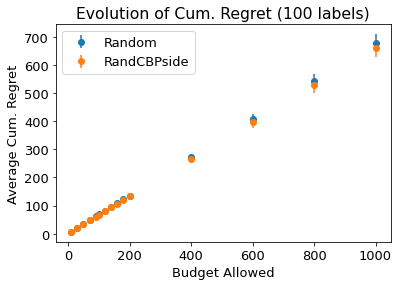

In [116]:


regret_random = []
regret_cbp = []

error_random = []
error_cbp = []

for verification_budget in budgets:
    regrets1 = history[verification_budget]['regret_RandCBPside']
    regrets2 = history[verification_budget]['regret_Random']

    regret1 = [ np.cumsum(r)[-1] for r in regrets1 ]
    regret2 = [ np.cumsum(r)[-1] for r in regrets2 ]

    regret_cbp.append(  np.mean(regret1 ) )
    regret_random.append(  np.mean( regret2 ) )

    error_cbp.append(  np.std(regret1 ) )
    error_random.append(  np.std( regret2 ) )

plt.errorbar(budgets, regret_random, error_random, linestyle='None', marker='o', label = 'Random')
plt.errorbar(budgets, regret_cbp, error_cbp, linestyle='None', marker='o', label = 'RandCBPside')

plt.legend()
plt.title('Evolution of Cum. Regret (100 labels)')

plt.xlabel('Budget Allowed')
plt.ylabel('Average Cum. Regret')



plt.savefig('./regret_100.png')

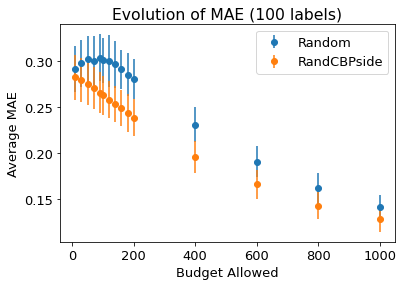

In [117]:
MAE_random = []
MAE_cbp = []

error_random = []
error_cbp = []

for verification_budget in budgets:
    erreurs1 = history[verification_budget]['erreur_RandCBPside']
    erreurs2 = history[verification_budget]['erreur_Random']
    MAE1 = [ sum(err) / len(err) for err in erreurs1 ]
    MAE2 = [ sum(err) / len(err) for err in erreurs2 ]
    MAE_cbp.append(  np.mean(MAE1) )
    MAE_random.append(  np.mean(MAE2) )
    
    error_cbp.append(  np.std(MAE1 ) )
    error_random.append(  np.std( MAE2 ) )

plt.errorbar(budgets, MAE_random, error_random, linestyle='None', marker='o', label = 'Random')
plt.errorbar(budgets, MAE_cbp, error_cbp, linestyle='None', marker='o', label = 'RandCBPside')
plt.title('Evolution of MAE (100 labels)')
plt.xlabel('Budget Allowed')
plt.ylabel('Average MAE')
plt.legend()
plt.savefig('./MAE_100.png')

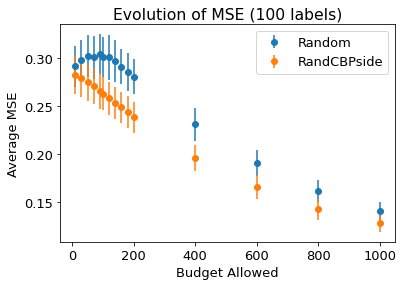

In [118]:
MSE_random = []
MSE_cbp = []

error_random = []
error_cbp = []

for verification_budget in budgets:
    erreurs1 = history[verification_budget]['erreur_RandCBPside']
    erreurs2 = history[verification_budget]['erreur_Random']
    MSE1 = [ sum( np.array(err)**2 ) / len(err) for err in erreurs1 ]
    MSE2 = [ sum( np.array(err)**2 ) / len(err) for err in erreurs2 ]
    MSE_cbp.append(  np.mean(MSE1) )
    MSE_random.append(  np.mean(MSE2) )

    error_cbp.append(  np.std(MSE1 ) )
    error_random.append(  np.std( MSE2 ) )


plt.errorbar(budgets, MAE_random, error_random, linestyle='None', marker='o', label = 'Random')
plt.errorbar(budgets, MAE_cbp, error_cbp, linestyle='None', marker='o', label = 'RandCBPside')

plt.title('Evolution of MSE (100 labels)')
plt.xlabel('Budget Allowed')
plt.ylabel('Average MSE')
plt.legend()
plt.savefig('./MSE_100.png')

In [20]:
import pandas as pd





df = np.vstack( [ np.array([0,1,2,3,4,5,6,7,8,9]),  np.round( final_probas , 2) ] ).T
df = pd.DataFrame(df)
df.columns = ['index', 'ground_truth'] 

for k in estimates_history.keys():
    df[str(k)] = estimates_history[k]

steps = round( (224 - 96) / len(estimates_history.keys() ) )
greys = np.arange(224, 96, -steps)

fig = go.Figure( )

for i , k in enumerate( estimates_history.keys() ):
    col = greys[i]
    fig.add_trace(go.Scatter(x=df['index'], y=df[str(k)], line=dict(color='rgb({},{},{})'.format(col,col,col) ) ,mode='lines+markers',  name='{} rounds'.format(k),   showlegend=True ))

fig.add_trace(go.Scatter(x=df['index'], y=df['ground_truth'], text = df['ground_truth'],  line=dict(color='rgb(255,0,0)' ), textfont=dict( family="sans serif", size=18) ,mode='lines+markers+text',  name='Deployment Error (ground truth)',   showlegend=True ))

fig.update_traces(textposition="top center")

fig.update_layout(yaxis_range=[-0.1,1])

fig.show(legend=True)
# fig.write_image("./estimates_imbalanced.png")

In [ ]:
import gzip
import pickle as pkl

n_cores = 8
n_folds = 25
horizon = 2500

game = games.apple_tasting(False)

algos = [ random_algo.Random(  game, horizon, ),    
          cpb_side.CPB_side(  game, horizon, 1.01, 0.05), 
          cpb_side_gaussian.RandCPB_side(game, horizon, 1.01, 0.05, 1/8, 10, False, 10e-7),
          linucb.LinUCB(game, horizon, 1.01)   ] #cpb_side_gaussian.CPB_side_gauss(game, horizon, 1/16, 10)

colors = [  [0,0,0], [250,0,0], [0,250,0] , [0,0,250]  ] #, [250,0,0]
labels = [  'random', 'CBP-side 0.05',  'RandCPB-side 0.001', 'linUCB' ] #  'Rand CPB-side'

fig = go.Figure( )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
    np.save('./results/apple_tasting/easy_context_{}_{}_{}'.format(horizon,n_folds, label), result)
    regret =  np.mean(result,0) 
    
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )  )
    
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )

fig.show(legend=True)

# fig.write_image("./easy_AT_context.pdf")

#fig.update_xaxes(type="log")
# fig.write_image("./easy_AT_context_log.pdf")

fig.show()

In [12]:
import gzip
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np

# direct = './use_case_results/{}'.format(name)

with gzip.open( './use_case_results/random_10.pkl.gz','rb') as f:
    result1 = pkl.load(f)

with gzip.open( './use_case_results/randcbpside_100.pkl.gz','rb') as f:
    result2 = pkl.load(f)

fina_regret1 = [ result1[i][-1] for i in range(len(result1)) ]
fina_regret2 = [ result2[i][-1] for i in range(len(result2)) ]

data = [fina_regret1, fina_regret2]
 
# fig = plt.figure(figsize =(10, 7))
 
# # # Creating axes instance
# ax = fig.add_axes([0])
 
# Creating plot
# bp = plt.boxplot(data)
 
# show plot
# plt.show()

In [13]:
fina_regret2

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]